# Task 3: Customer Segmentation / Clustering

# Data set


Customers.csv:
https://drive.google.com/file/d/1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE/view?usp=sharing

Transactions.csv :
https://drive.google.com/file/d/1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF/view?usp=sharing


# Files Description:
1. Customers.csv
○ CustomerID: Unique identifier for each customer.
○ CustomerName: Name of the customer.
○ Region: Continent where the customer resides.
○ SignupDate: Date when the customer signed up.
 
2. Transactions.csv
○ TransactionID: Unique identifier for each transaction.
○ CustomerID: ID of the customer who made the transaction.
○ ProductID: ID of the product sold.
○ TransactionDate: Date of the transaction.


# Importing liberaries 


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

 

In [4]:
# Load data
customers_df = pd.read_csv("C:/Users/ARCHANA/Desktop/Zeotap/Customers.csv", parse_dates=['SignupDate'])
transactions_df =pd.read_csv("C:/Users/ARCHANA/Desktop/Zeotap/Transactions.csv")

In [5]:

# Display the first few rows of each dataset to understand their structure
customers_df.head()
transactions_df.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [6]:
# Merge the datasets on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

# Feature engineering: calculate total expenditure, transaction frequency, and average purchase value
customer_features = merged_df.groupby("CustomerID").agg(
    total_expenditure=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    average_value=("TotalValue", "mean")
).reset_index()

# Add regional information
customer_features = pd.merge(customer_features, customers_df[["CustomerID", "Region"]], on="CustomerID", how="left")

# Display the processed data
customer_features.head()


,CustomerID,total_expenditure,transaction_count,average_value,Region
0,C0001,3354.52,5,670.904,South America
1,C0002,1862.74,4,465.685,Asia
2,C0003,2725.38,4,681.345,South America
3,C0004,5354.88,8,669.360,South America
4,C0005,2034.24,3,678.080,Asia


In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
 

# Encode the 'Region' column
label_encoder = LabelEncoder()
customer_features["Region_encoded"] = label_encoder.fit_transform(customer_features["Region"])

# Select features for clustering
features = customer_features[["total_expenditure", "transaction_count", "average_value", "Region_encoded"]]

# Normalize the data
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Perform clustering with K-Means for a range of clusters (2 to 10)
db_indices = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_normalized)
    db_index = davies_bouldin_score(features_normalized, labels)
    db_indices.append((n_clusters, db_index))

# Find the optimal number of clusters (minimum DB index)
optimal_clusters = min(db_indices, key=lambda x: x[1])[0]

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans.fit_predict(features_normalized)

# Display the DB Index values for each number of clusters and the optimal clusters
db_indices, optimal_clusters


([(2, 1.3531239389376095),
  (3, 1.3297804752635893),
  (4, 1.2322768822445056),
  (5, 1.139725290893224),
  (6, 1.063615123489301),
  (7, 1.0346786995440096),
  (8, 0.9795086644089563),
  (9, 0.9848360801486956),
  (10, 0.9791411357584809)],
 10)

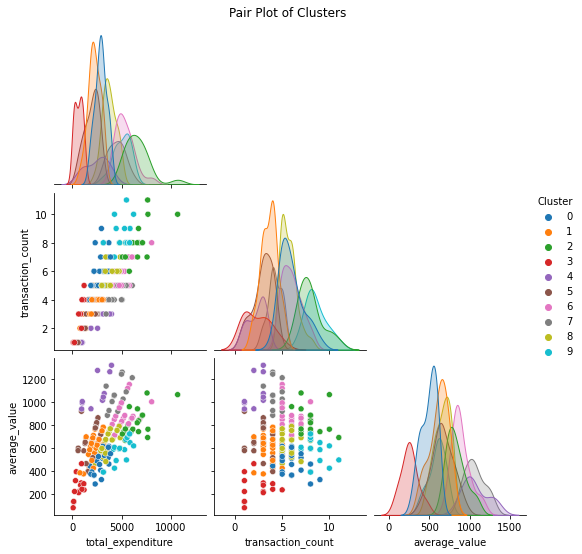

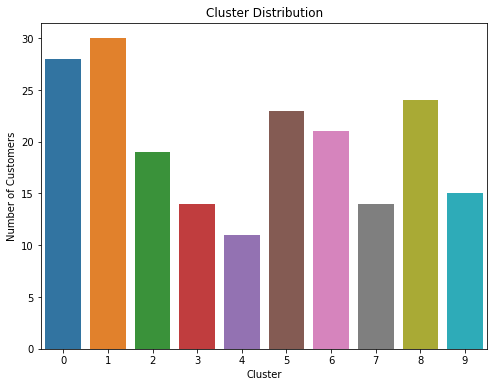

In [8]:
# Visualize clusters using a pair plot
sns.pairplot(
    customer_features,
    vars=["total_expenditure", "transaction_count", "average_value"],
    hue="Cluster",
    palette="tab10",
    diag_kind="kde",
    corner=True
)
plt.suptitle("Pair Plot of Clusters", y=1.02)
plt.show()

# Visualize cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="Cluster", data=customer_features, palette="tab10")
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()
